# opticam_new's Reducer()

`opticam_new`'s `Reducer()` object makes reducing OPTICAM data quick (depending on the number of images) and easy. In this notebook, I will explain each of `Reducer()`'s routines, why the defaults are what they are, and how these defaults can be tweaked to suit a user's specific needs.

The first step is to initialise the `Reducer()` object. This requires directory paths to be passed to the `data_directory` and `out_directory` parameters, indicating where the raw data are, and where the reduced data should be saved, respectively. In this case, we will use the test data generated in the Basic Usage tutorial:

In [1]:
from opticam_new import Reducer

reducer = Reducer(
    data_directory='Data',  # path to the directory containing the test data
    out_directory='Reduced',  # path to the directory where the reduced data will be saved
    show_plots=True
)

[OPTICAM] Scanning files ...


100%|██████████| 8/8 [00:00<00:00, 18.97it/s]

[OPTICAM] Done.
[OPTICAM] Binning: 8x8
[OPTICAM] Filters: g-band, i-band, r-band
[OPTICAM] Read transforms from file.
[OPTICAM] Read g-band catalog from file.
[OPTICAM] Read i-band catalog from file.
[OPTICAM] Read r-band catalog from file.


`Reducer()` can take a number of other parameters, but they can also be left undefined such that the default values can be used instead. The default values for `background`, `local_background` and `finder` are explained in dedicated tutorials, but here I will explain the rest:
- `threshold`: this is the threshold factor for source detection, in terms of background RMS, and defaults to 5 (i.e., a 5 sigma detection). For faint sources, this value may be reduced. For bright sources, this value may be increased. I have found that anything above 4 generally works pretty well, while anything less than 3 generally results in a lot of phantom sources being identified.
- `aperture_selector`: this determines how the PSF is estimated. When sources are identified, they will generally yield different semi-major and semi-minor axes. The `aperture_selector` parameter determines how the PSF is estimated from the distribution of semi-major and semi-minor axes. The default aperture selector will select the median semi-major and semi-minor axes if the largest aperture is greater than one standard deviation above the median, otherwise it will return the maximum aperture. Below, we will see how to implement a custom aperture selector.
- `scale`: the aperture scale factor, by default 5. This scales the PSF and determines the aperture size when generating the catalogs, as well as the aperture sizes for the forced photometry methods.
- `remove_cosmic_rays`: whether to remove cosmic rays before extracting source fluxes, by default True.
- `number_of_processors`: the number of processors to use, by default half the number of available processors. Increasing this value may increase performance, while decreasing it may reduce memory usage.
- `show_plots`: whether plots should be displayed as they're rendered, by default True.
- `verbose`: whether to output progress to the command line, by default True.

## Initialising Catalogs

Once a `Reducer()` instance has been initialised, the next step is to initialise the catalogs. When initialising catalogs, there are three parameters that can be tweaked:
- `n_alignment_sources`: determines the number of sources used for image alignment, defaults to 3 (minimum required for computing translation, rotation, and scaling).
- `transform_type`: determines the transform type, defaults to 'translation'. Three different transformations are available for aligning images: 'euclidean' (rotation and translation), 'similarity' (rotation, translation, and scaling), and 'translation' (translation only, default). In most cases, alignments should have negligible rotation and scaling components, however, they are included just in case.
- `overwrite`: whether to overwrite any existing catalog files in `out_directory`, defaults to False.

Let's initialise our catalogs using the default parameter values:

[OPTICAM] Initialising catalogs ...
[OPTICAM] Aligning and stacking g-band images in batches ...


100%|██████████| 8/8 [00:32<00:00,  4.00s/it]

[OPTICAM] Done. 0 image(s) could not be aligned.
[OPTICAM] Aligning and stacking i-band images in batches ...



100%|██████████| 8/8 [00:38<00:00,  4.83s/it]

[OPTICAM] Done. 0 image(s) could not be aligned.
[OPTICAM] Aligning and stacking r-band images in batches ...



100%|██████████| 8/8 [00:22<00:00,  2.78s/it]


[OPTICAM] Done. 0 image(s) could not be aligned.


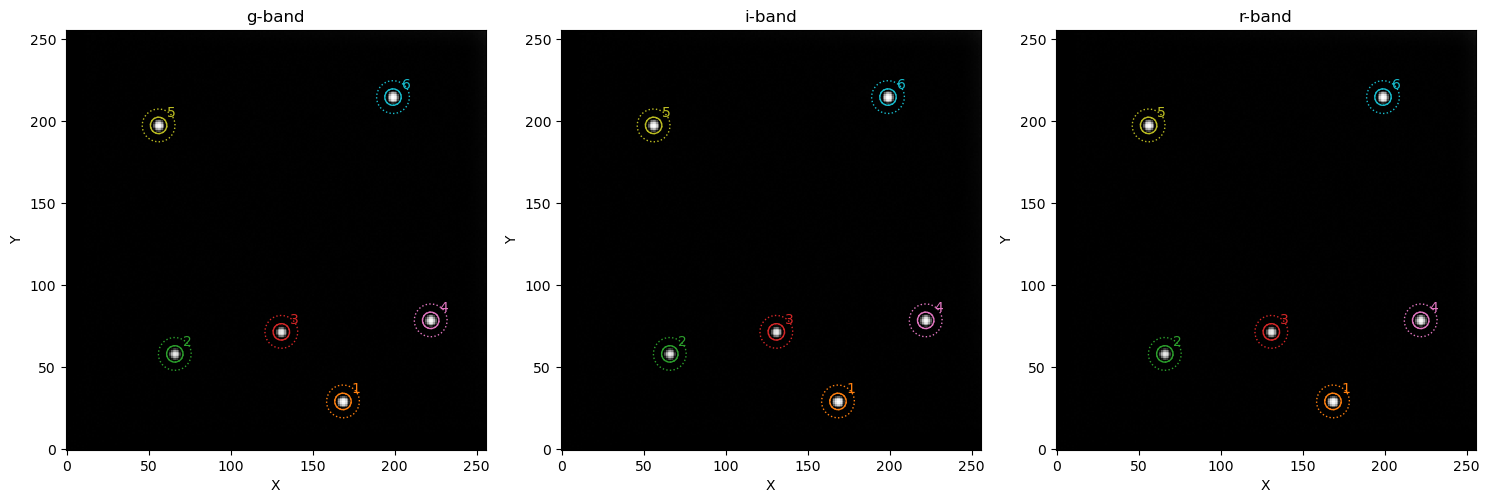

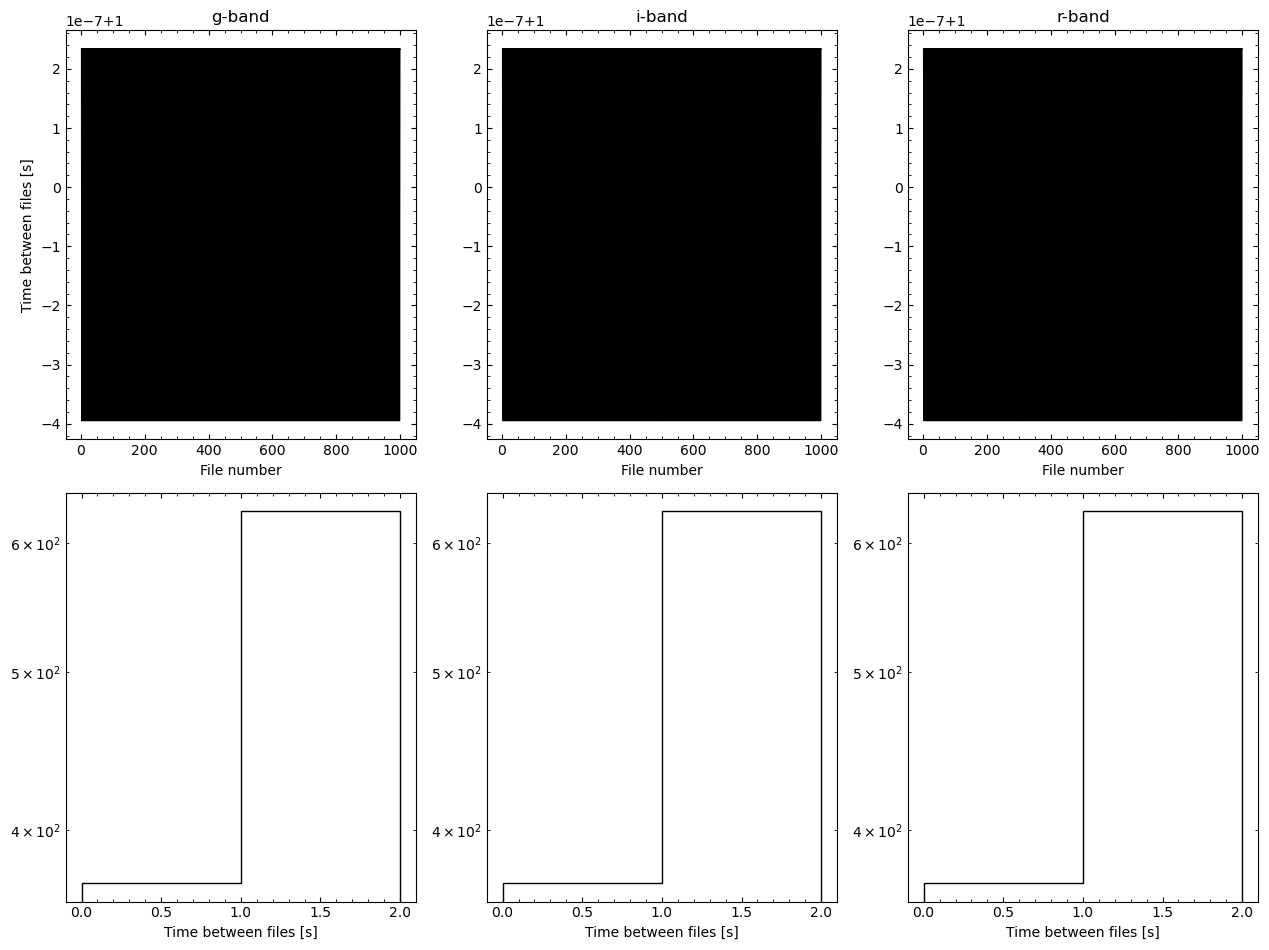

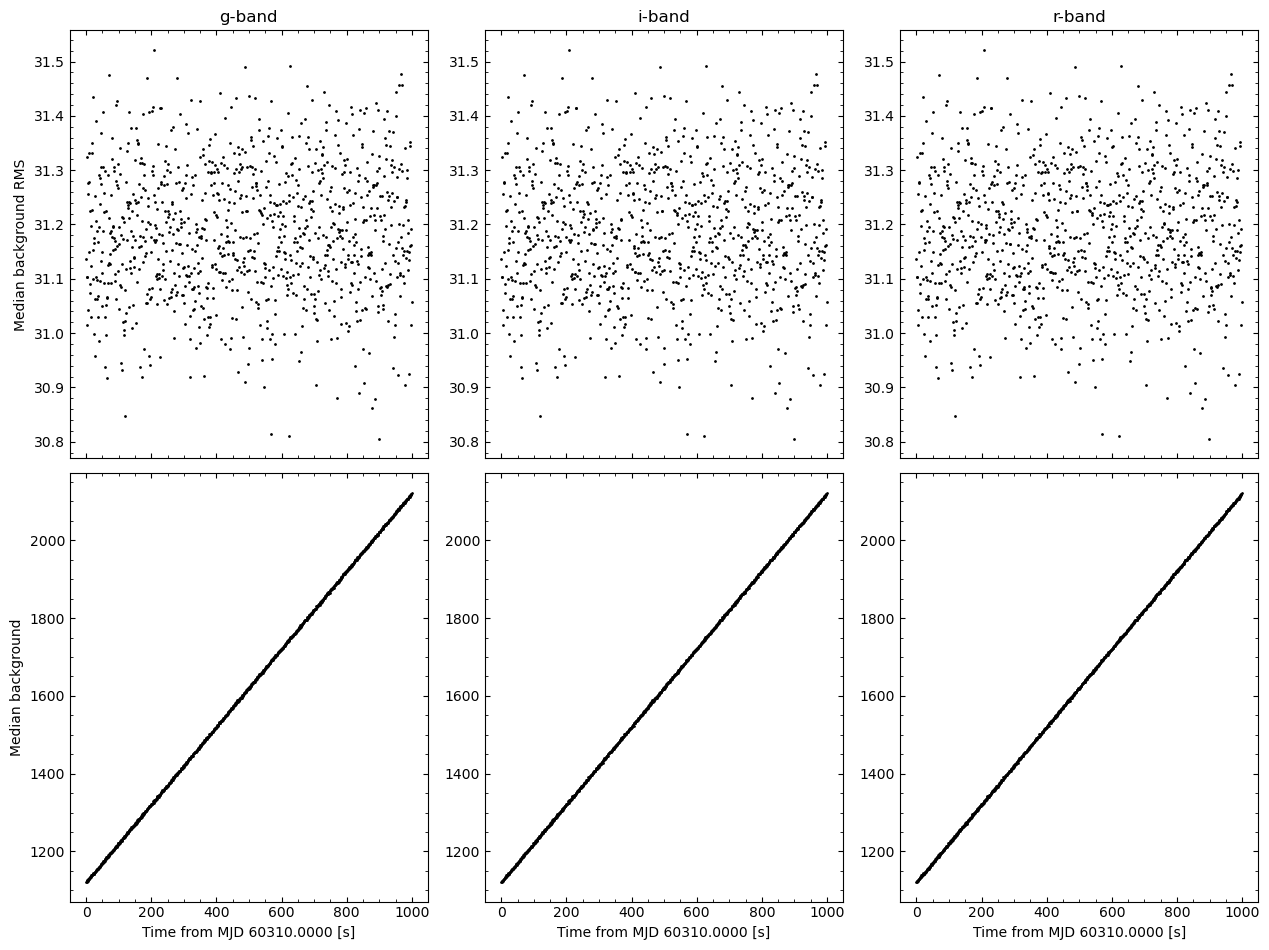

In [2]:
reducer.initialise_catalogs(overwrite=True)

The `initialise_catalogs()` method produces four plots, all of which are saved to `out_directory`. From top to bottom, these plots are:
- The source catalogs (saved to `out_directory/cat/catalogs.png`). This shows the detected sources for each filter, giving each source a numbered label, and shows the aperture and annulus size that will be used to perform forced photometry (determined by the `aperture_selector` and `scale` parameters of `Reducer()`).
- The time between observations (saved to `out_directory/diag/header_times.png`). This is included so the user can check the times between images, which can be useful for identifying large time gaps between images (if, for example, two sets of observations were accidentally saved in the same directory, the observations were disrupted due to bad weather, etc.).
- The average background as a function of time (saved to `out_directory/diag/background.png`). The average background as a function of time is included to help the user distinguish intrumental systematics from intrinsic source variability.

### Custom Aperture Selector

It is straightforward to implement custom aperture selectors for `opticam_new`'s `Reducer()`. Below, I implement a custom aperture selector that returns the mean aperture size if the variance in aperture sizes is less than 1 pixel, otherwise it returns the maximum aperture size. This custom aperture selector was defined arbitrarily and is only for demonstrative purposes (though it may work well in practise in some cases):

[OPTICAM] Scanning files ...


100%|██████████| 8/8 [00:00<00:00, 17.55it/s]

[OPTICAM] Done.
[OPTICAM] Binning: 8x8
[OPTICAM] Filters: g-band, i-band, r-band
[OPTICAM] Read transforms from file.
[OPTICAM] Read g-band catalog from file.
[OPTICAM] Read i-band catalog from file.
[OPTICAM] Read r-band catalog from file.
[OPTICAM] Initialising catalogs ...
[OPTICAM] Aligning and stacking g-band images in batches ...



100%|██████████| 8/8 [00:24<00:00,  3.12s/it]

[OPTICAM] Done. 0 image(s) could not be aligned.
[OPTICAM] Aligning and stacking i-band images in batches ...



100%|██████████| 8/8 [00:25<00:00,  3.18s/it]

[OPTICAM] Done. 0 image(s) could not be aligned.
[OPTICAM] Aligning and stacking r-band images in batches ...



100%|██████████| 8/8 [00:26<00:00,  3.30s/it]


[OPTICAM] Done. 0 image(s) could not be aligned.


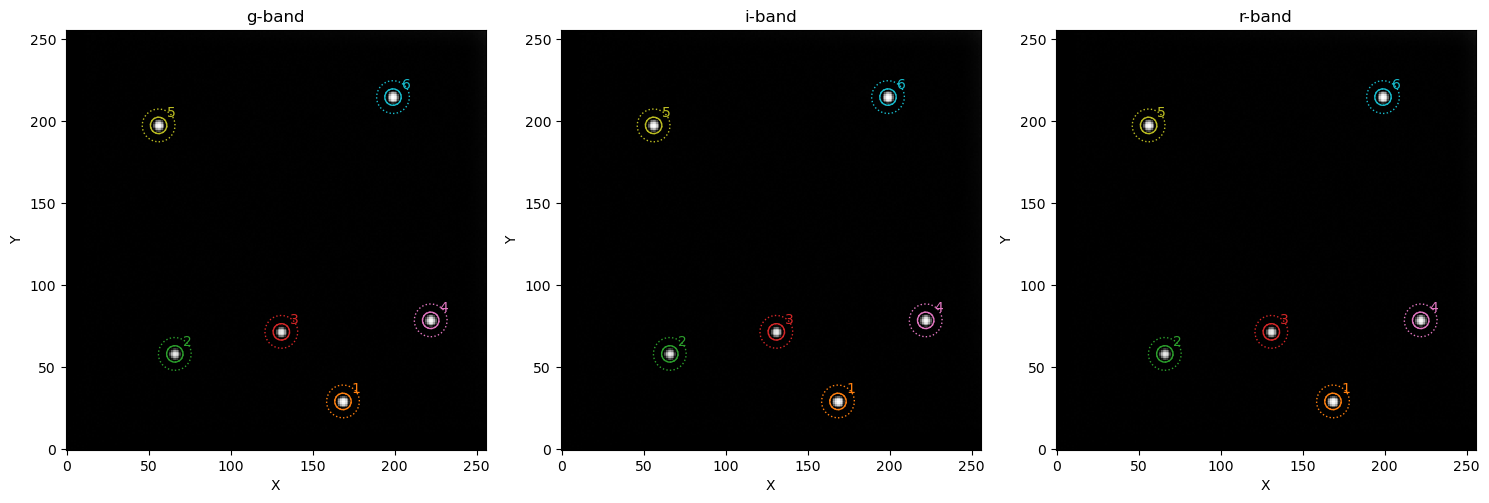

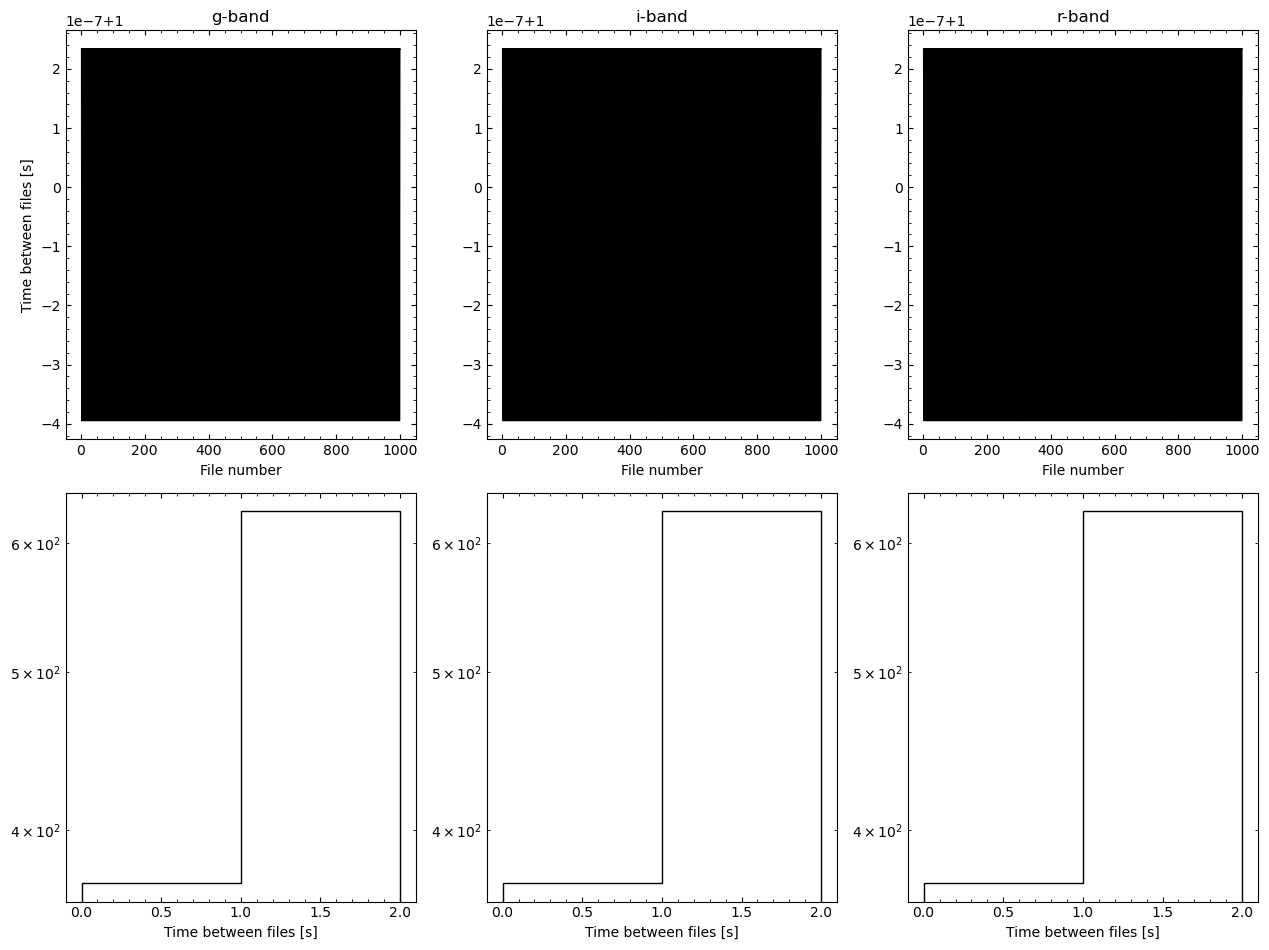

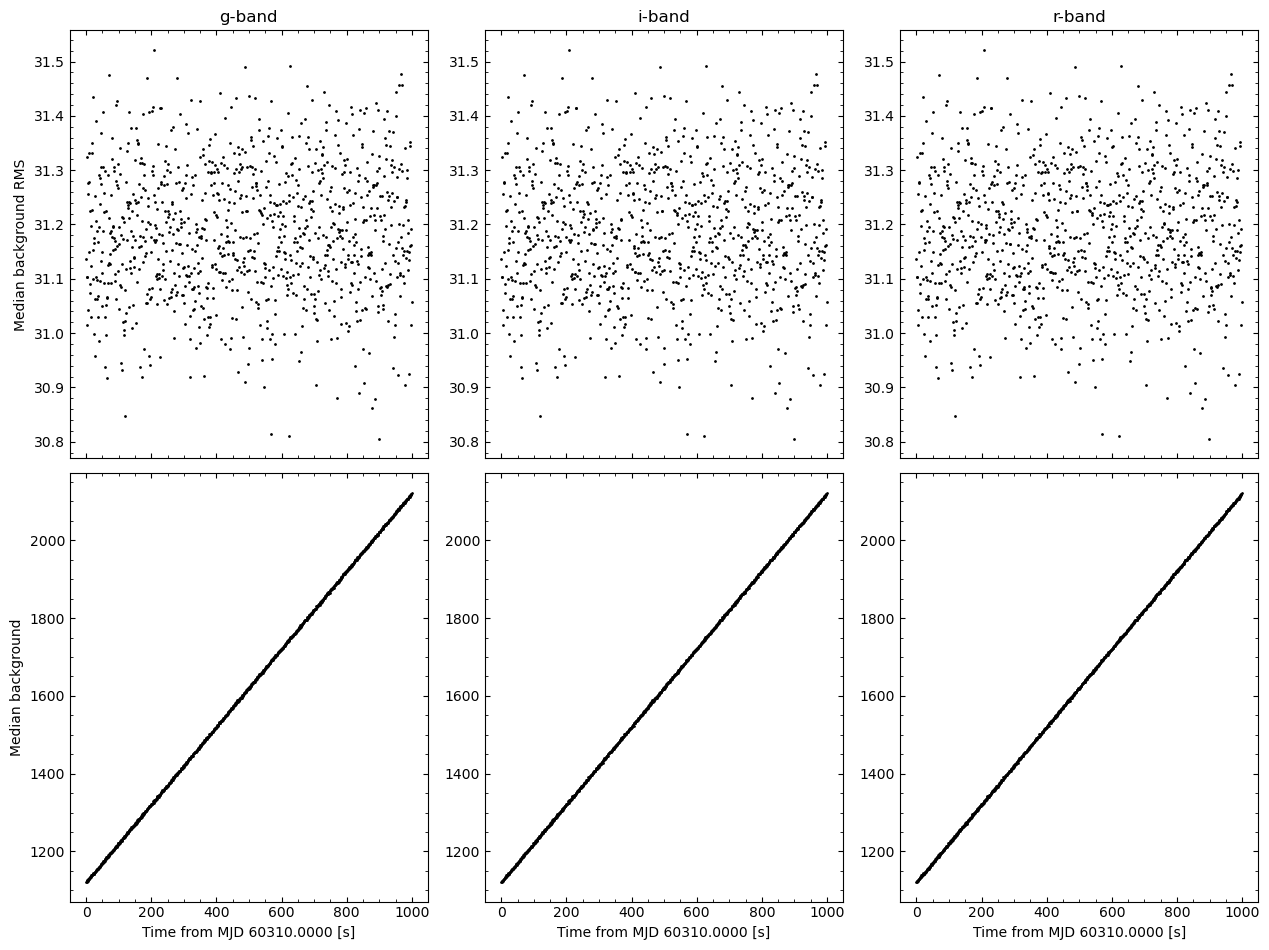

In [3]:
import numpy as np

def custom_aperture_selector(aperture_sizes):
    
    # the aperture selector function takes an array of aperture sizes as input and returns a single floating point
    # number that defines the aperture size along the given axis (semi-major and semi-minor axes are determined
    # separately using the same function)
    
    variance = np.var(aperture_sizes)
    
    if variance <= 1:
        return np.mean(aperture_sizes)
    else:
        return aperture_sizes.max()


custom_reducer = Reducer(
    data_directory='Data',  # path to the directory containing the test data
    out_directory='Reduced',  # path to the directory where the reduced data will be saved
    show_plots=True,
    aperture_selector=custom_aperture_selector
)

custom_reducer.initialise_catalogs(overwrite=True)

As we can see, implementing custom aperture selectors is trivial. Hopefully, the default aperture selector is 'good enough' most of the time, but now you know how to implement a custom selector should you need to.

That concludes this notebook explaining `opticam_new`'s `Reducer()` object. Other methods are available, including the ability to create gifs and perform various types of photometry. These methods are not discussed here as they are fairly self-explanatory and largely influenced by how the `Reducer()` instance is defined. To see these other methods in action, check out the Basic Usage tutorial.